In [2]:
import anndata as ad
import episcanpy.api as epi
import scanpy as sc
import numpy as np
import time

/Users/anna.danese/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [3]:
import episcanpy
print(episcanpy.__version__)

0.1.7+23.g2bd1a9e


In [4]:
# define data directory
DATADIR = './data/'

In [6]:
# To load the peak matrix
adata = ad.read(DATADIR+'GSM3034622_BoneMarrow_62016_GSM3034623_BoneMarrow_62216_peakmatrix.h5ad')
adata

AnnData object with n_obs × n_vars = 12906 × 436206 
    obs: 'batch', 'cell', 'cell_label\n', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2'

In [7]:
# format cell label metadata
adata.obs['cell_label'] =[n.rstrip('\n') for n in adata.obs['cell_label\n']]
del adata.obs['cell_label\n']

In [8]:
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')


result_file = 'GSM3034622_BoneMarrow_62016_GSM3034623_BoneMarrow_62216_peakmatrix_processed.h5ad'

# Quality controls

In [9]:
# preliminary filtering
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

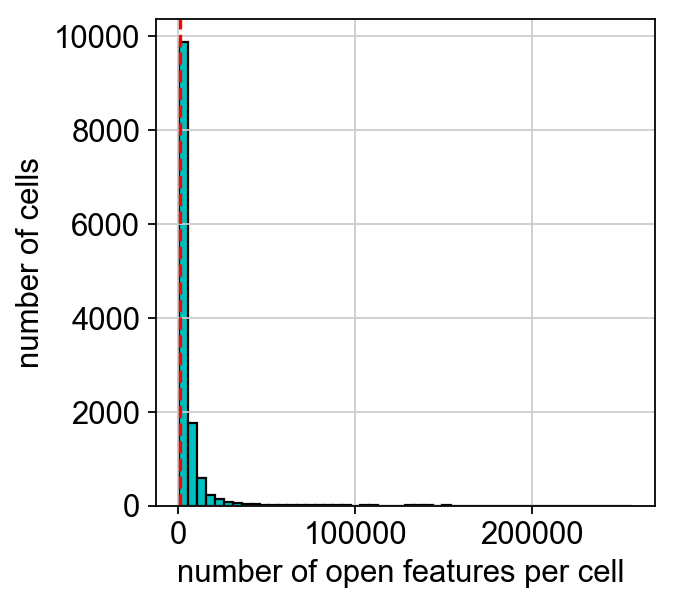

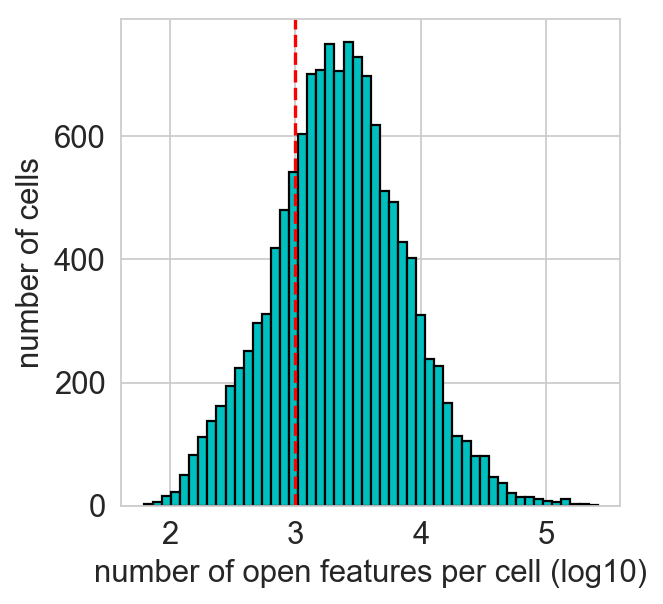

In [10]:
epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=1000, save='coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=1000, save='coverage_cells.png')

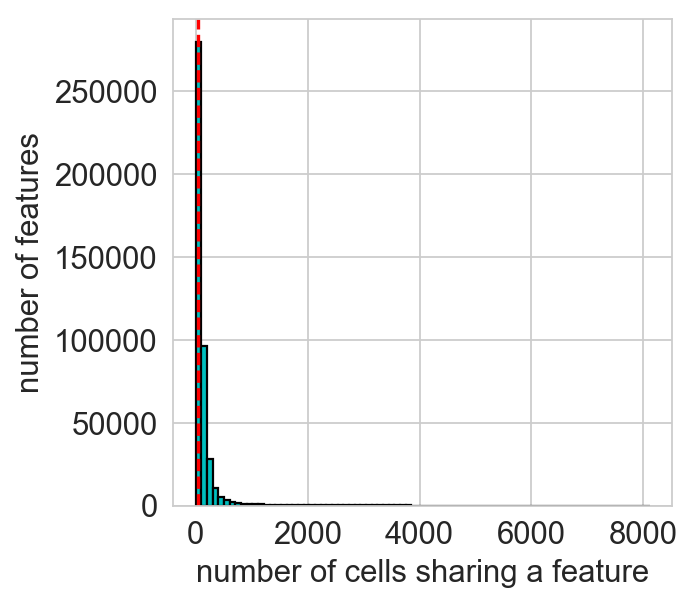

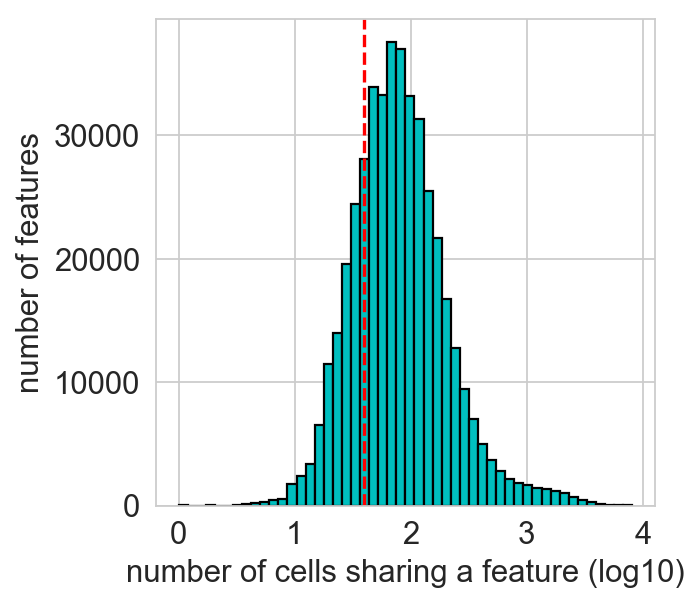

In [11]:
epi.pp.coverage_features(adata, binary=True, log=False, bins=50,
               threshold=40, save='coverage_cells.png')
epi.pp.coverage_features(adata, binary=True, log=10, bins=50,
               threshold=40, save='coverage_cells.png')

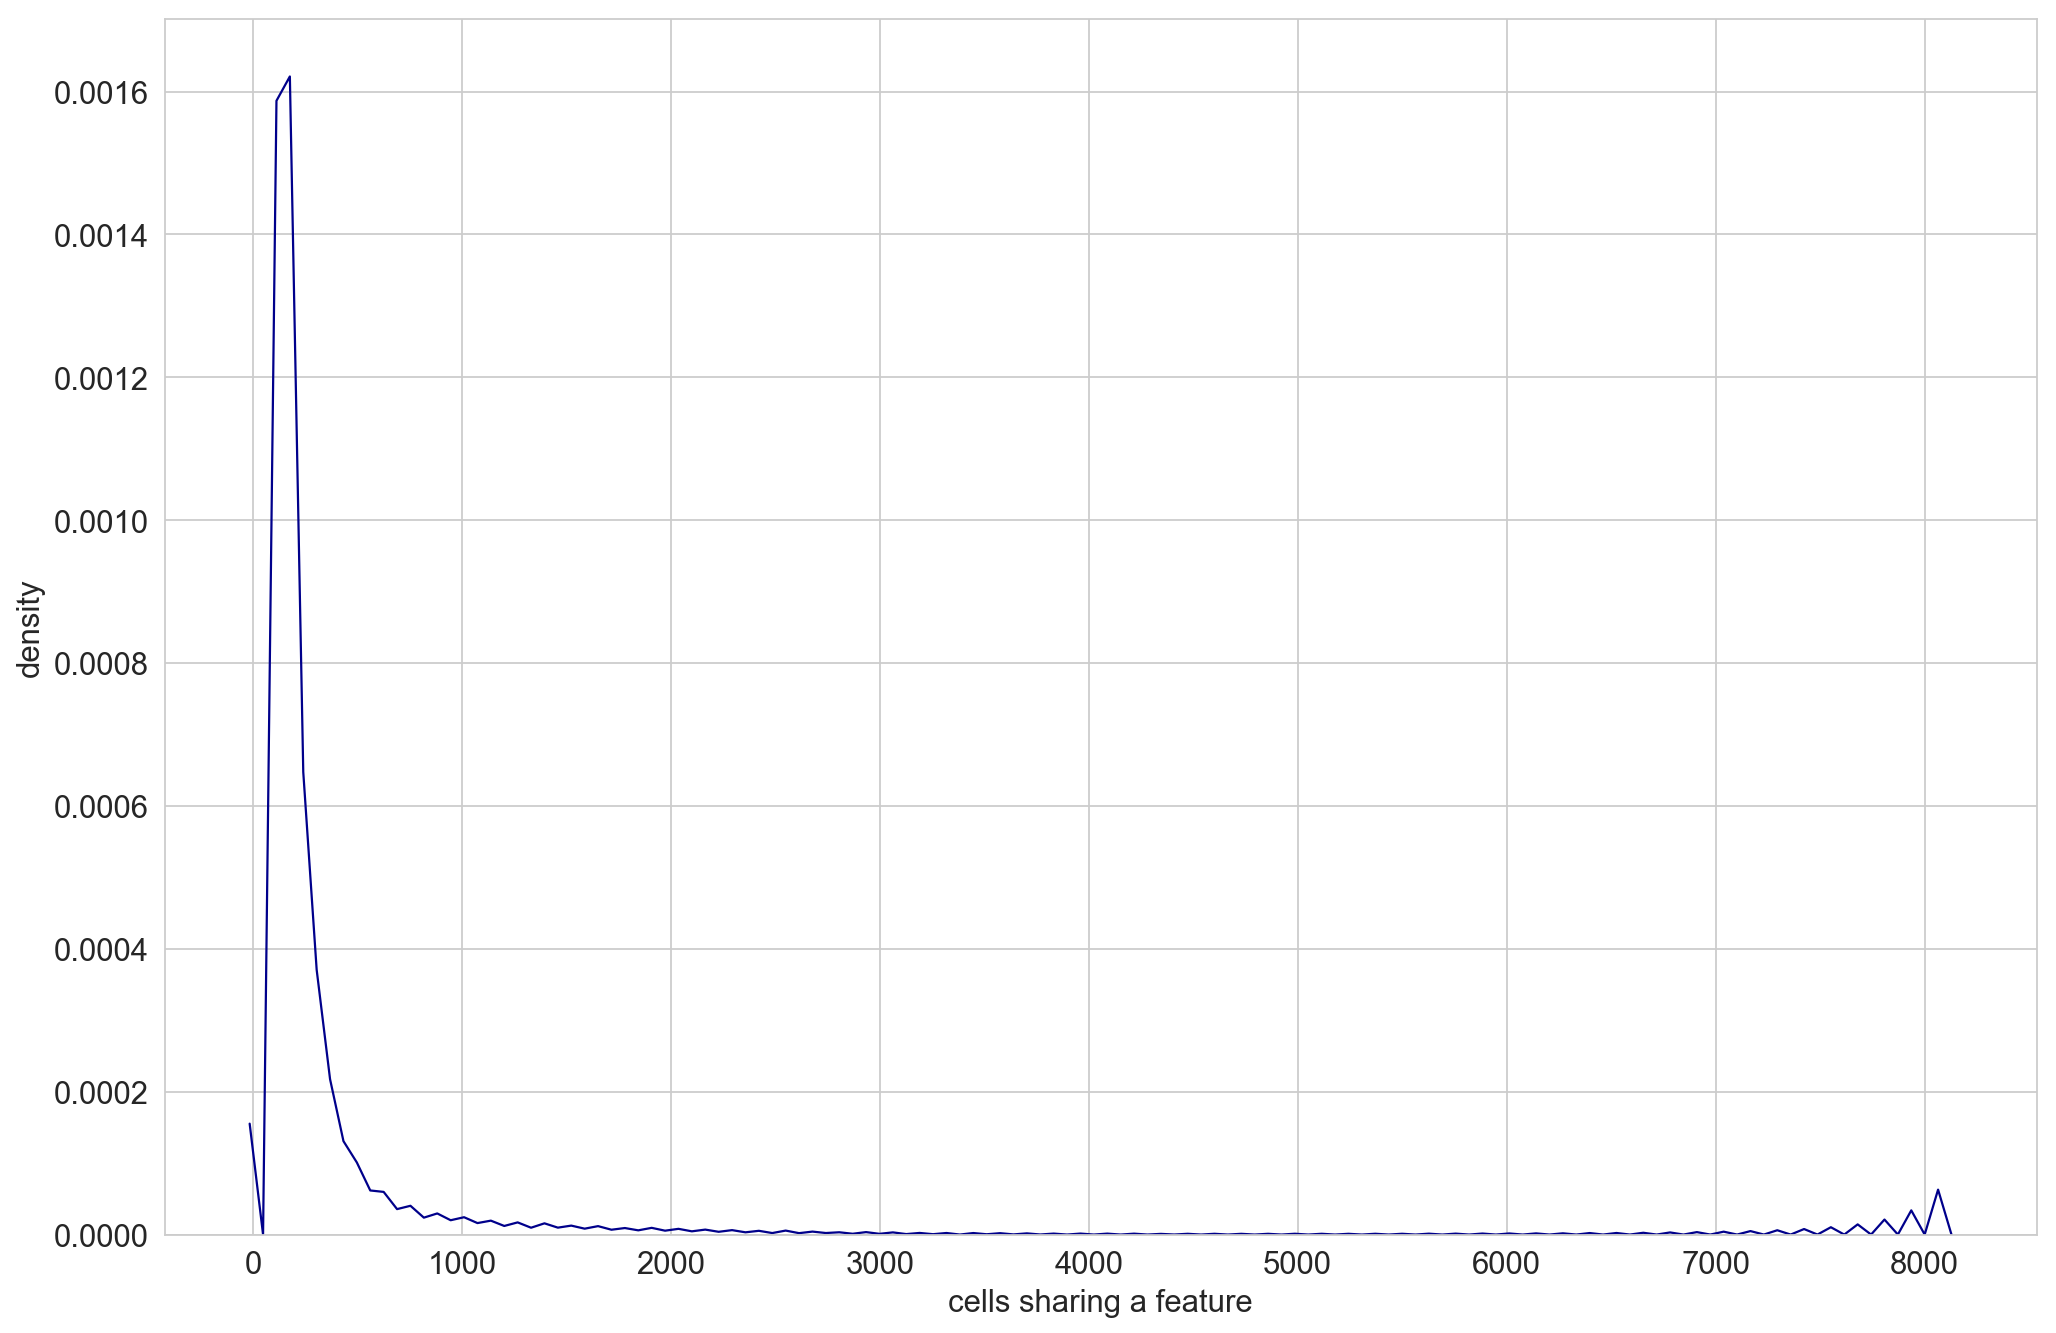

In [12]:
epi.pp.density_features(adata)

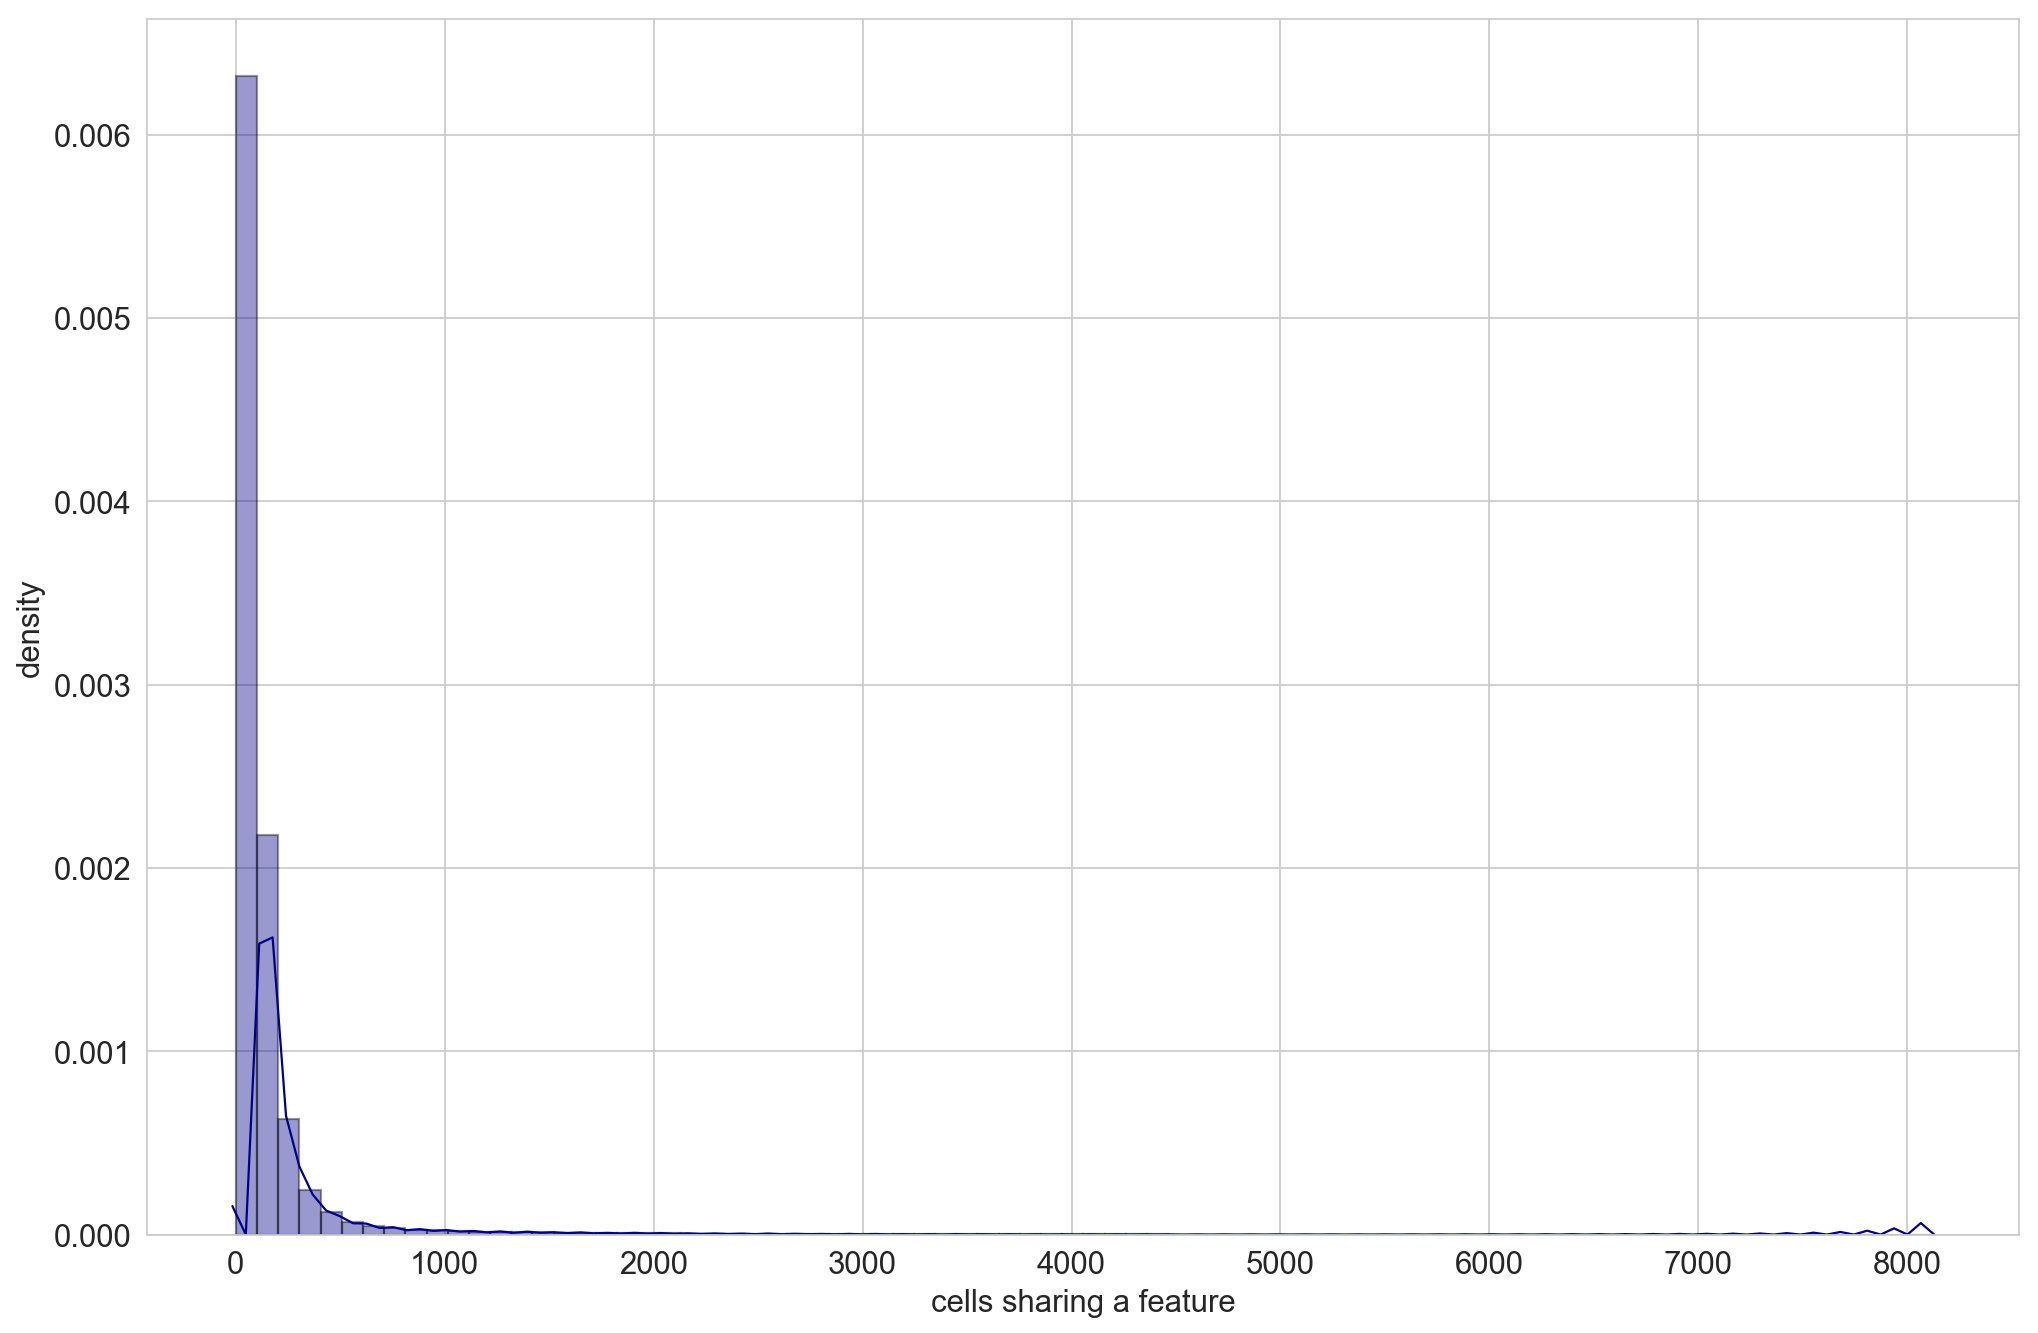

In [13]:
epi.pp.density_features(adata, hist=True)

### Actually filtering the cells

In [14]:
epi.pp.filter_cells(adata, min_features=1000)

In [15]:
epi.pp.filter_features(adata, min_cells=40)

#### Looking at the QC plots after filtering

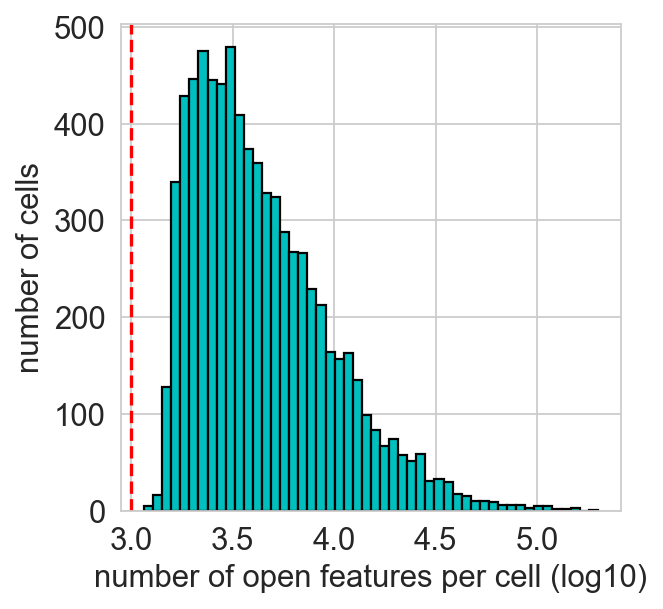

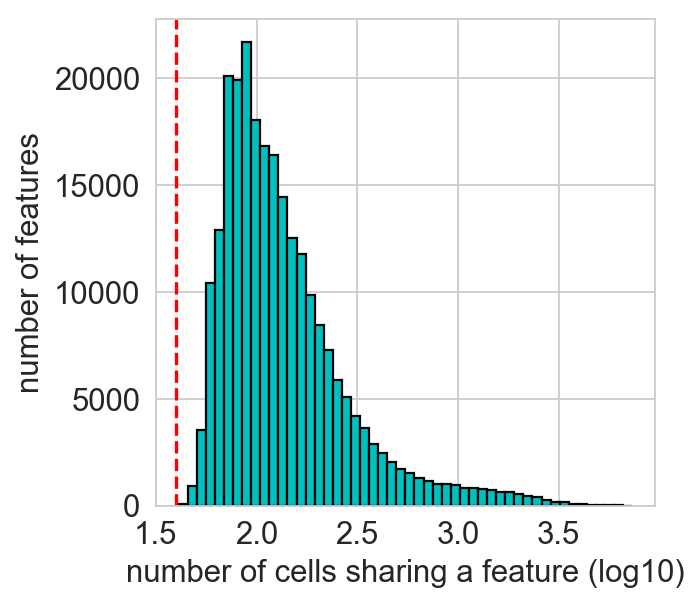

In [16]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=1000)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=40)

### Identifying the most variable features

In [17]:
adata

AnnData object with n_obs × n_vars = 7563 × 246595 
    obs: 'batch', 'cell', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2', 'cell_label', 'nb_features'
    var: 'n_cells', 'commonness'

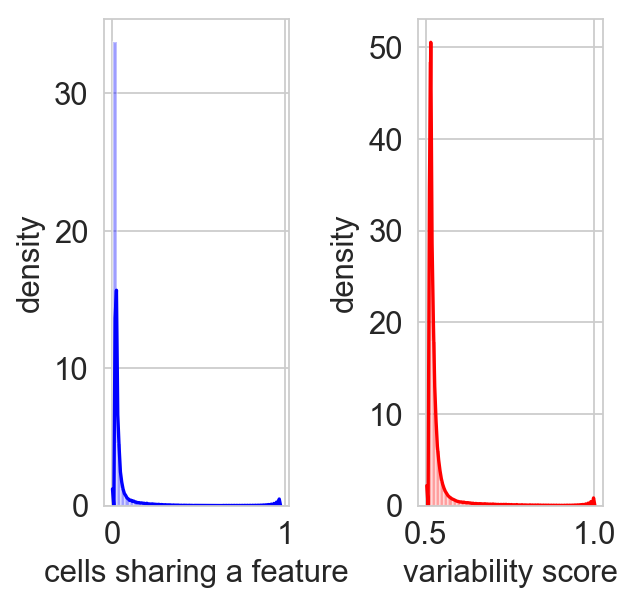

In [18]:
epi.pp.cal_var(adata)

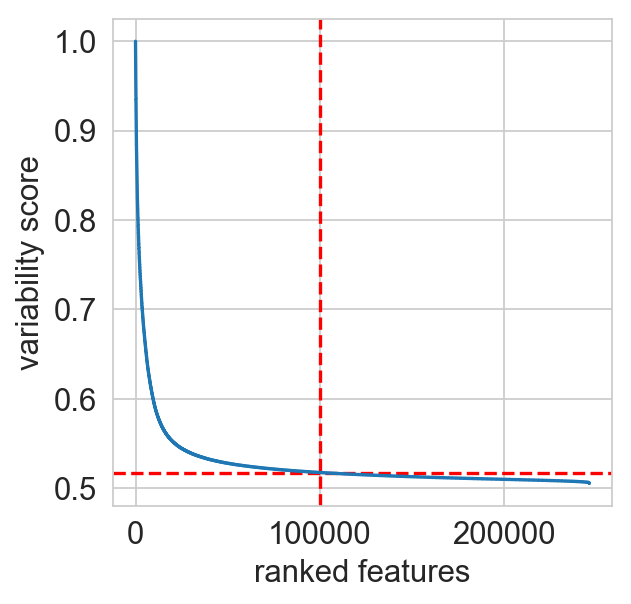

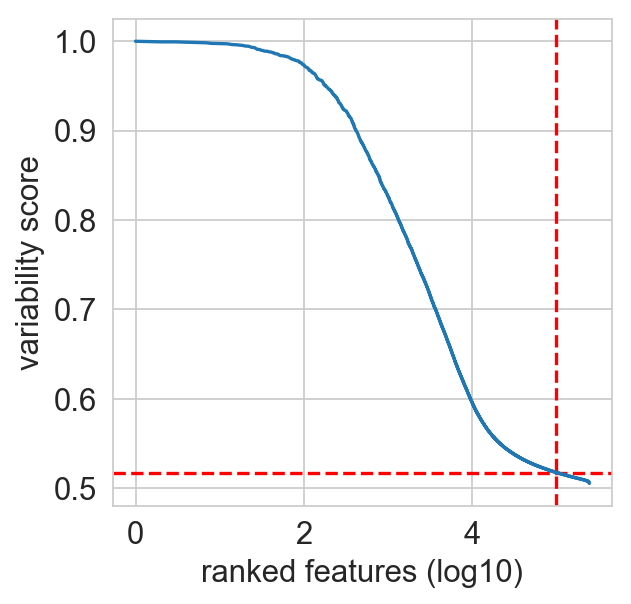

In [19]:
min_score_value = 0.517
nb_feature_selected = 100000
epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix_log10.png')

In [20]:
# save the current matrix in the raw layer
adata.raw = adata

In [21]:
# create a new AnnData w=containing only the most variable features
adata2 = epi.pp.select_var_feature(adata,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [22]:
adata2

View of AnnData object with n_obs × n_vars = 7563 × 100172 
    obs: 'batch', 'cell', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2', 'cell_label', 'nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

### Normalisation (correct library size)

In [23]:
epi.pp.normalize_per_cell(adata2)
epi.pp.log1p(adata2)

Trying to set attribute `.obs` of view, making a copy.


In [24]:
# save intermediary file
adata2.write(result_file)

... storing 'cell_label' as categorical


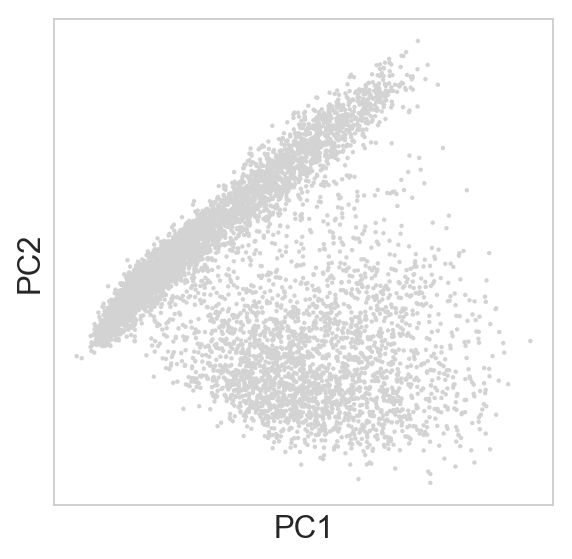

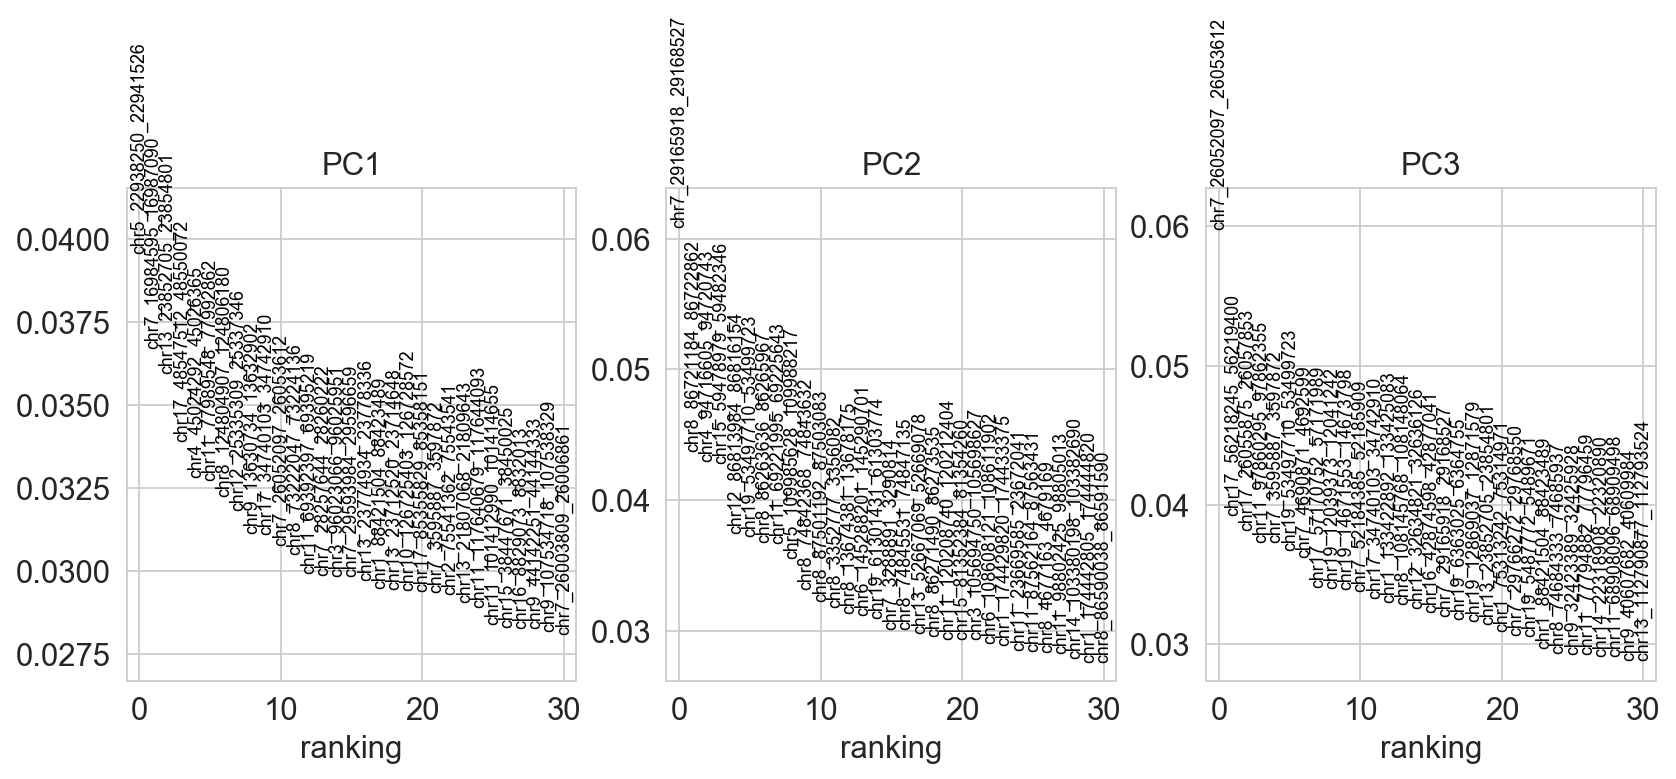

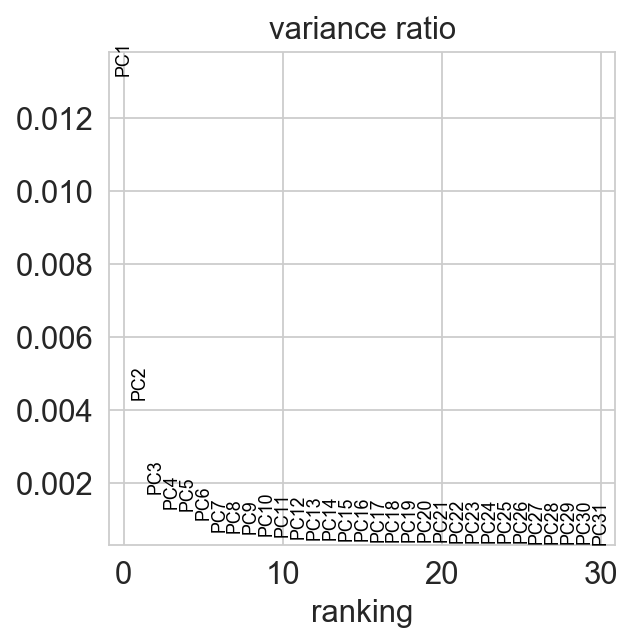

In [26]:
# Principal Component Analysis - Overview
epi.pp.pca(adata2)
epi.pl.pca_overview(adata2)

correlation: 0.1305271651612115
pval: 4.264692246254009e-30


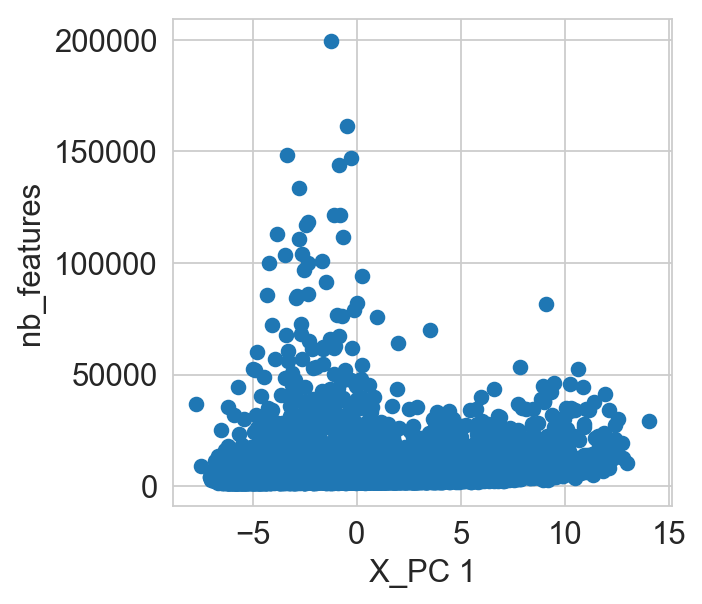

In [27]:
#Check if the coverage is a covariate to correct. Here is it is not the case anymore (post library size normalisation)
epi.pp.correlation_pc(adata2, 'nb_features')

### Principal Component Analysis

In [28]:
epi.pp.pca(adata2, n_comps=100)

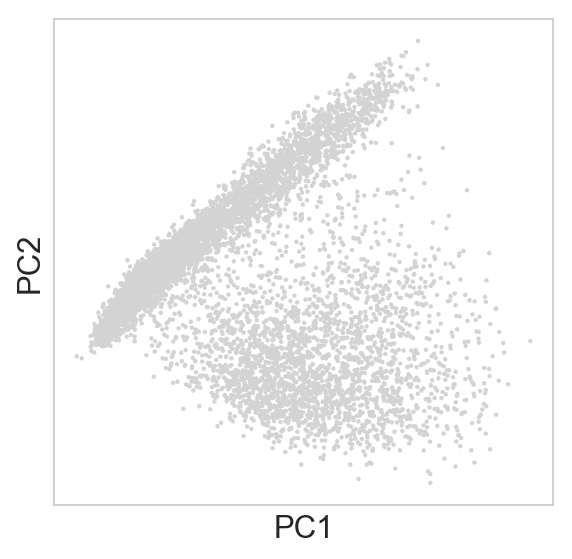

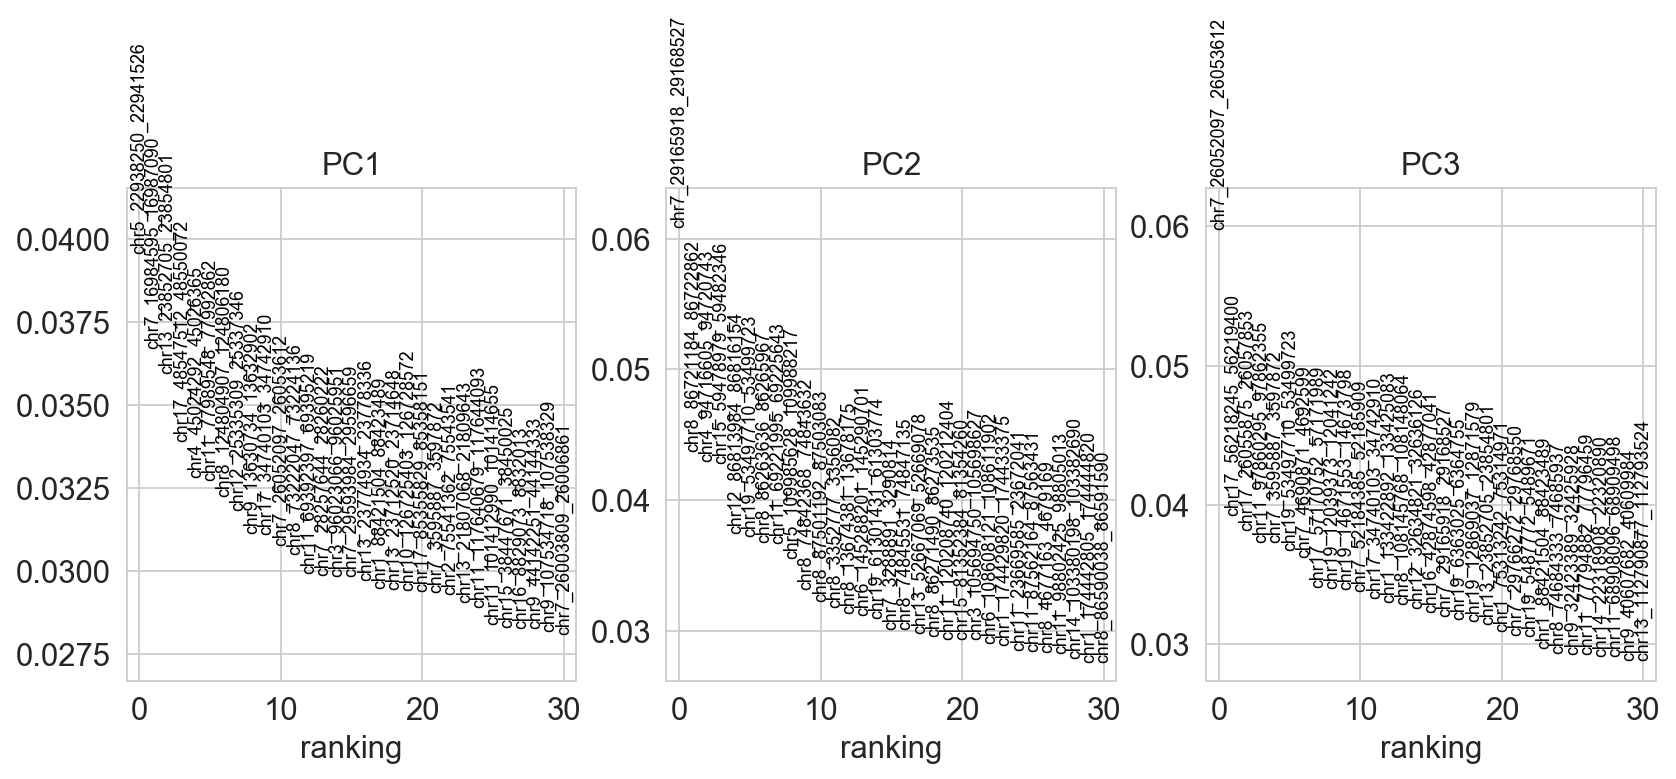

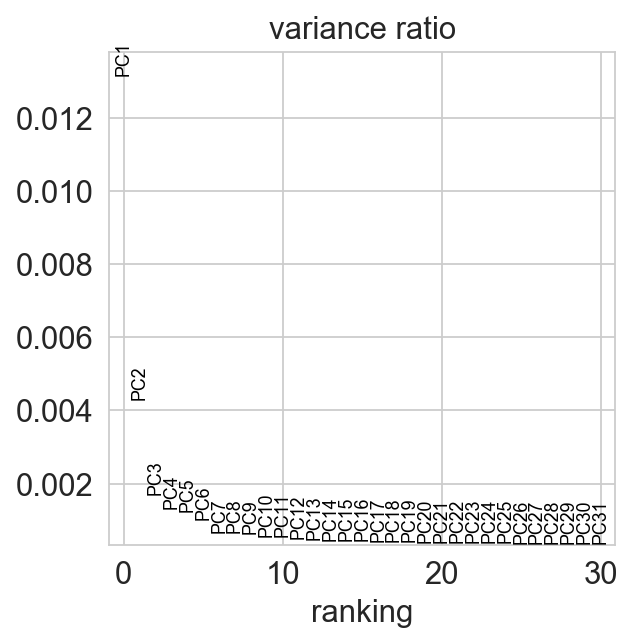

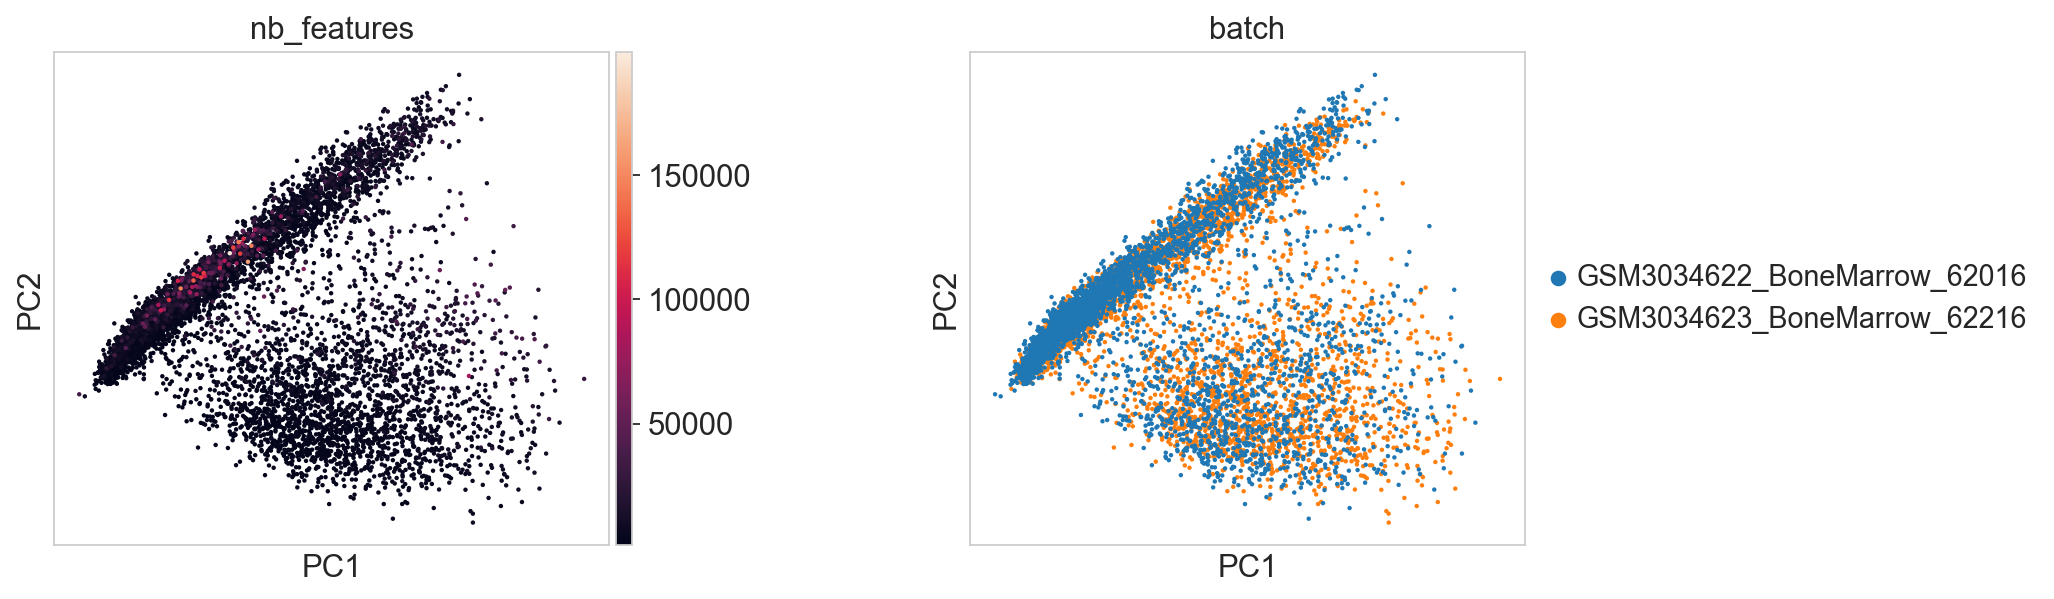

In [29]:
epi.pl.pca_overview(adata2)
sc.pl.pca(adata2, color=['nb_features', 'batch'], wspace=0.5)

### Neighboring graph and UMAP

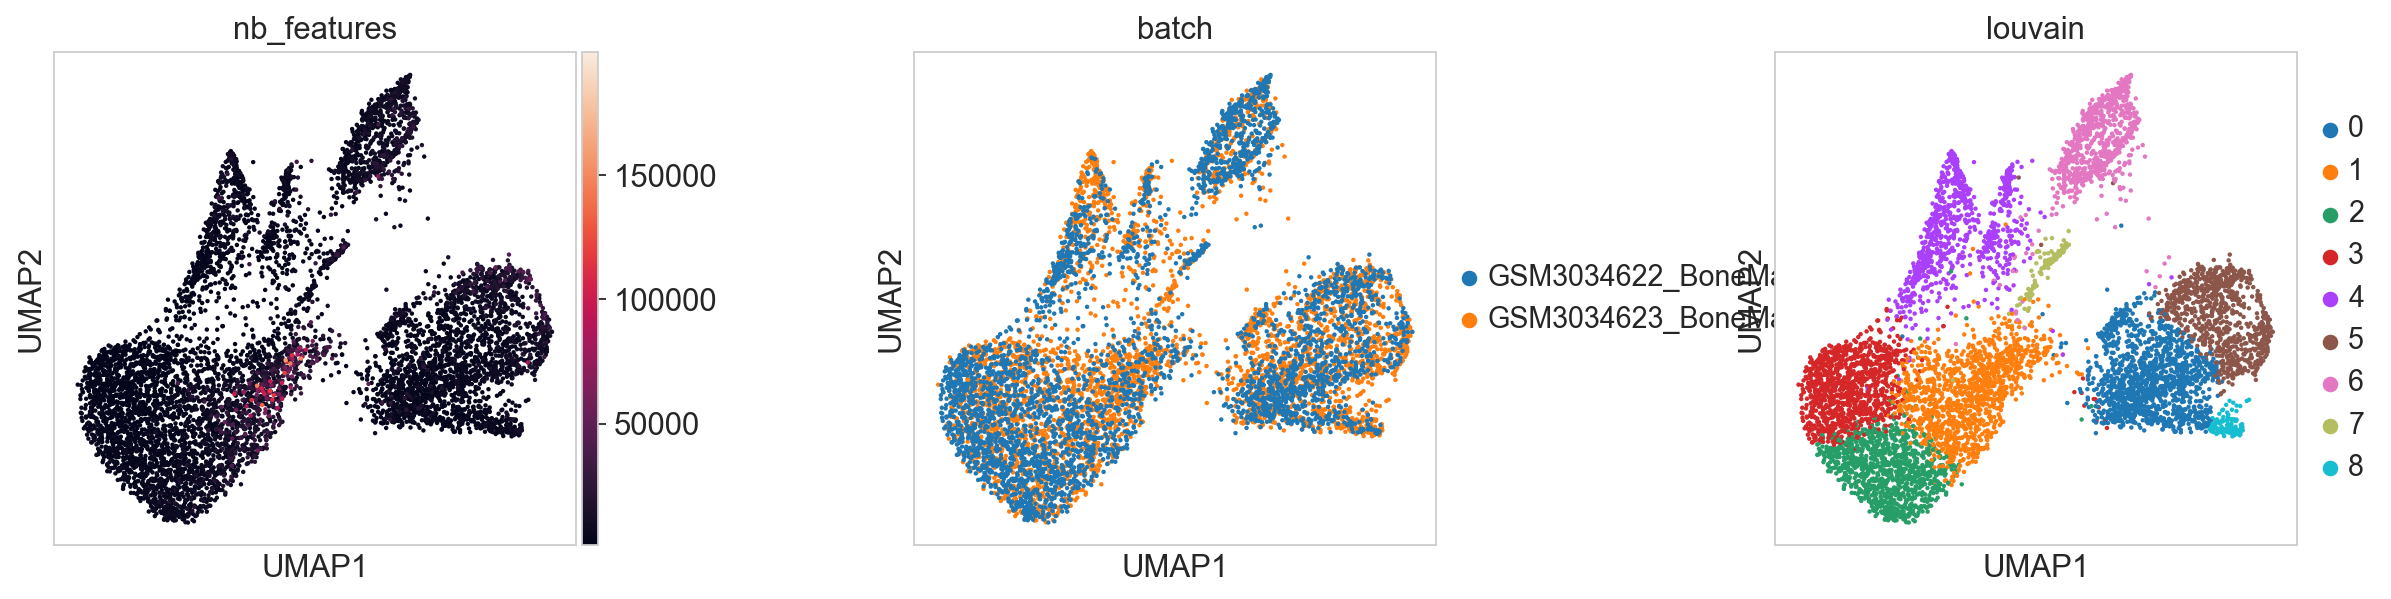

In [30]:
epi.pp.neighbors(adata2, n_neighbors=15, n_pcs=100, method='gauss')
epi.tl.umap(adata2, min_dist=0.5,spread=1, a=1,b=1)
epi.tl.louvain(adata2)
sc.pl.umap(adata2, color=['nb_features', 'batch', 'louvain'], wspace=0.5)

In [32]:
# calculate a second louvain clustering with a lower resolution
epi.tl.louvain(adata2, resolution=0.5, key_added='louvain_lowres')

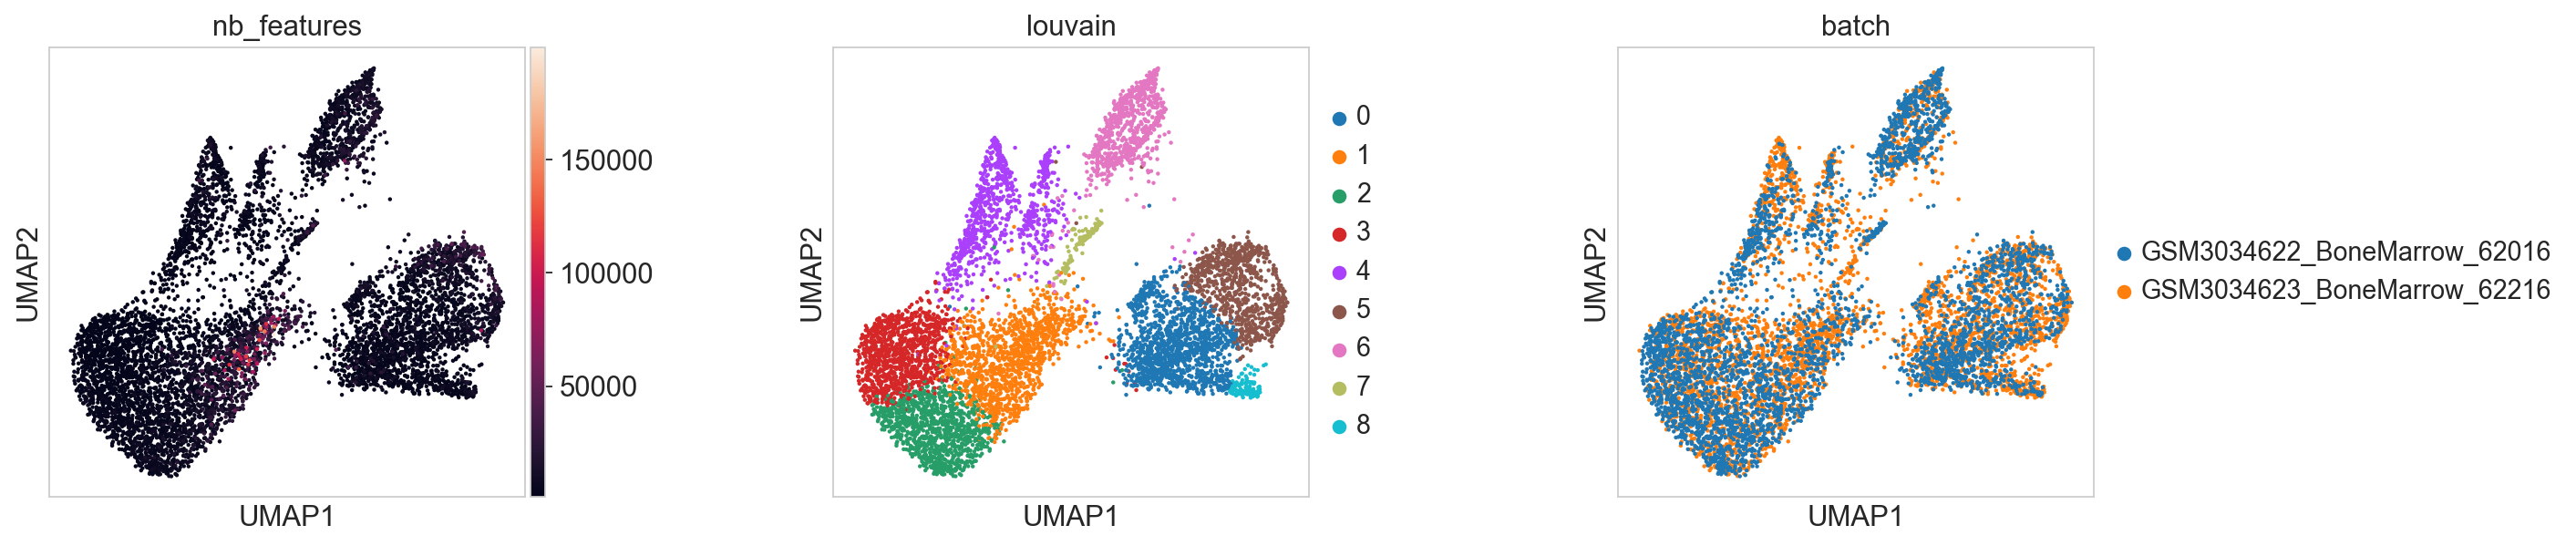

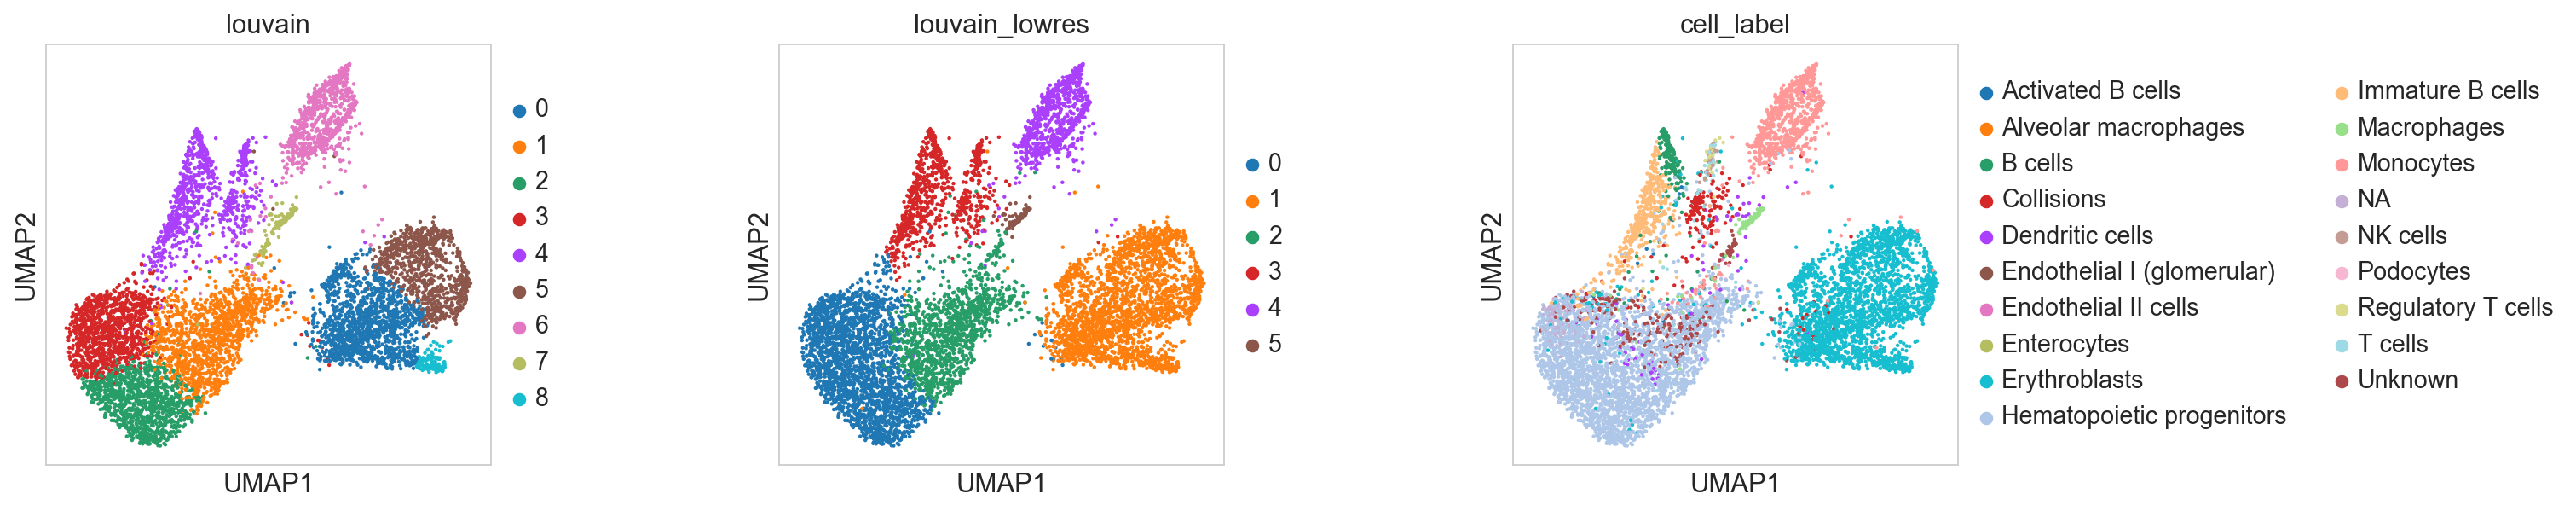

In [33]:
sc.pl.umap(adata2, color=['nb_features', 'louvain', 'batch'], wspace=0.5)
sc.pl.umap(adata2, color=['louvain', 'louvain_lowres', 'cell_label'], wspace=0.5)

### Diffusion Map

In [34]:
epi.tl.diffmap(adata2)

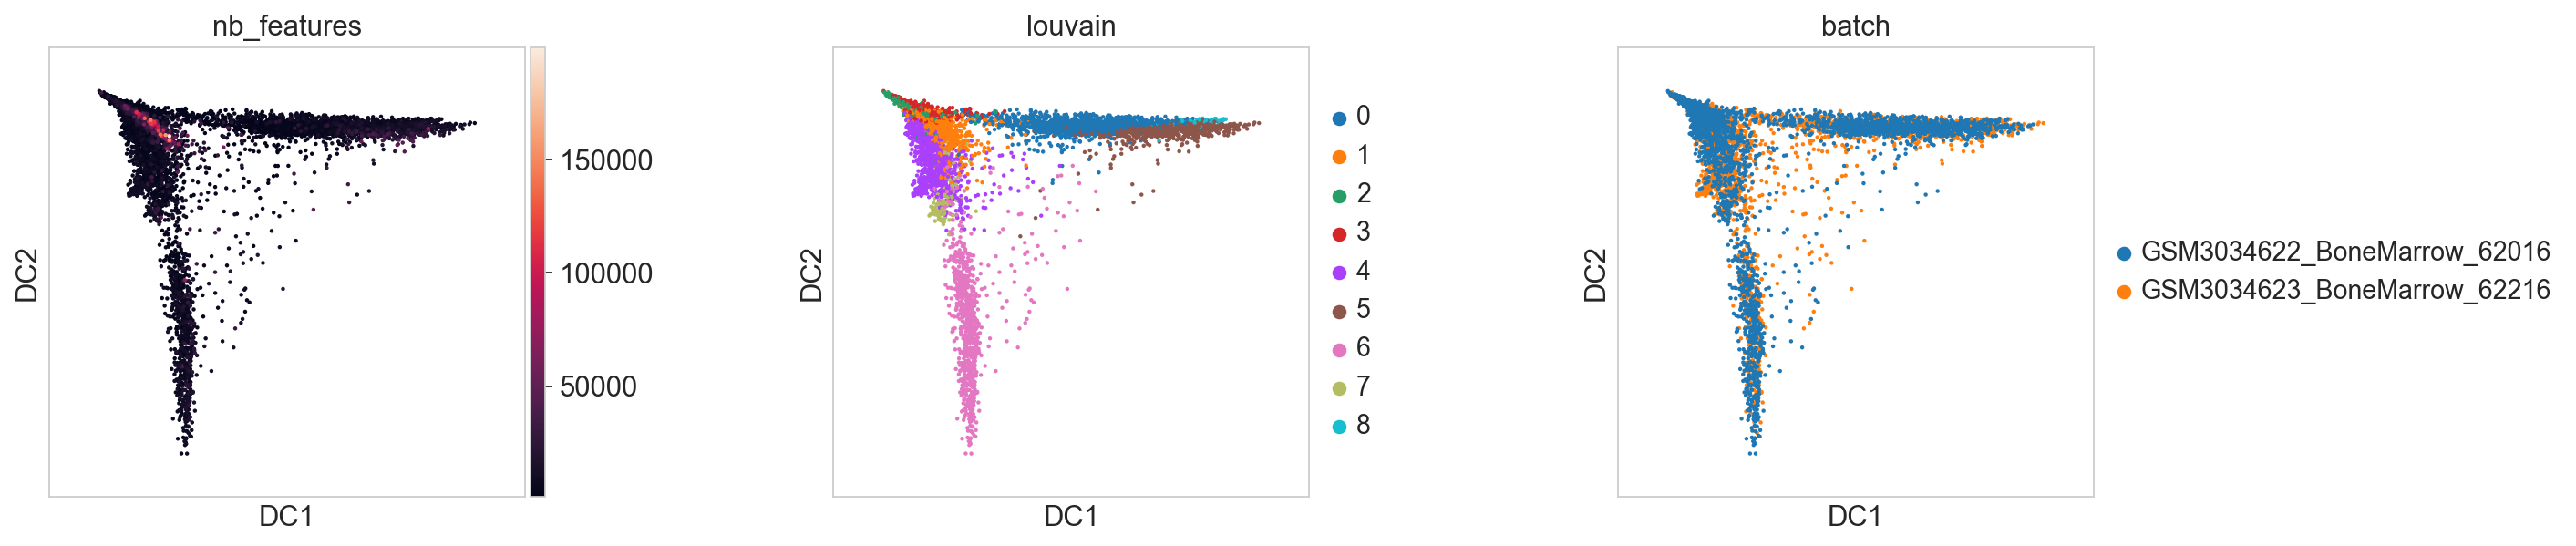

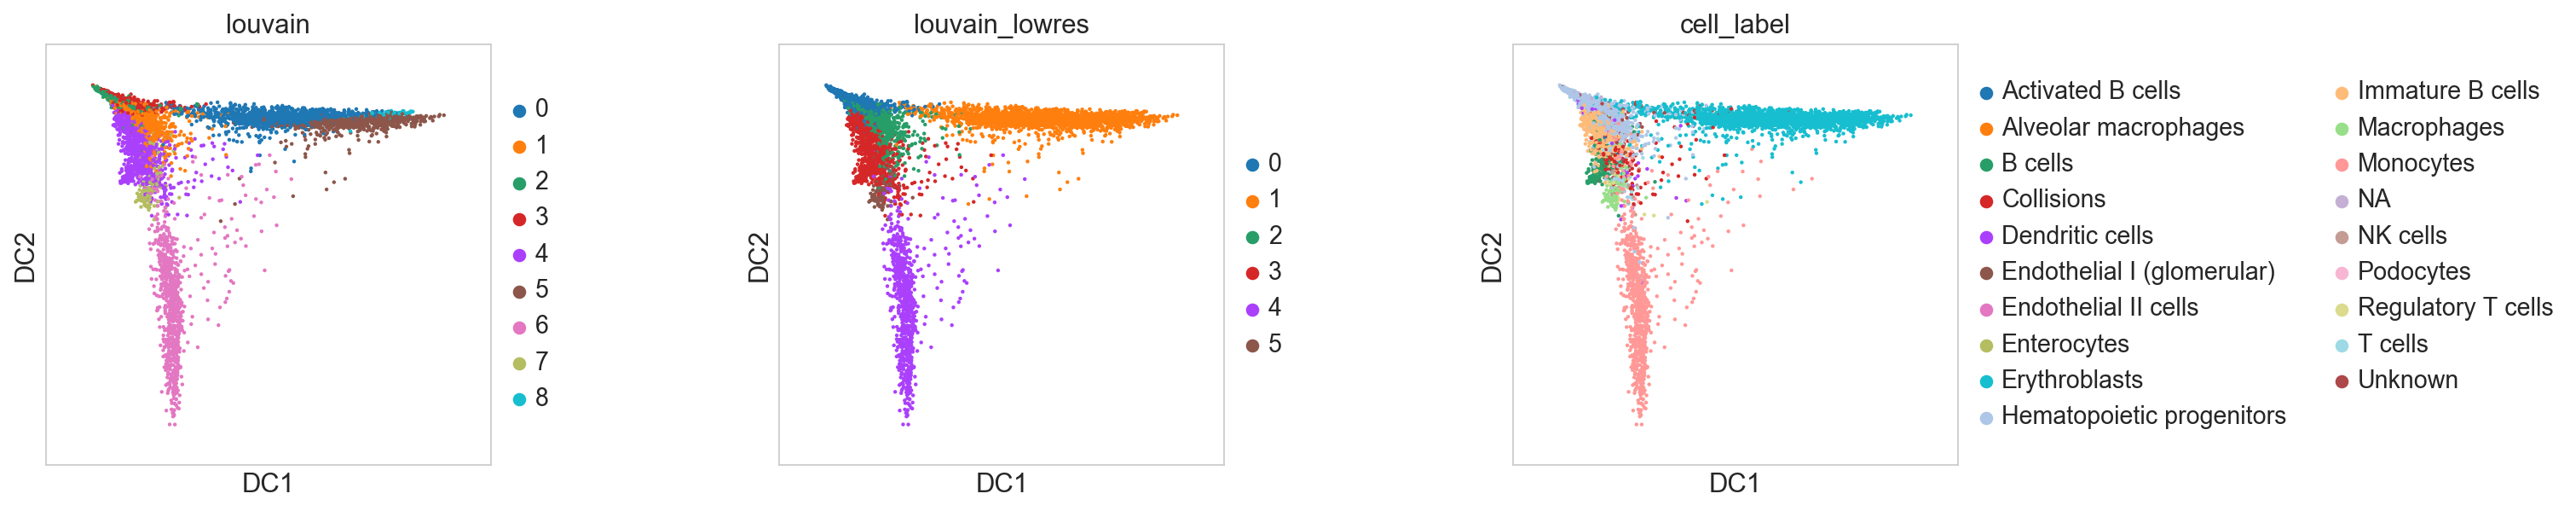

In [35]:
sc.pl.diffmap(adata2, color=['nb_features', 'louvain', 'batch'], wspace=0.5)
sc.pl.diffmap(adata2, color=['louvain', 'louvain_lowres', 'cell_label'], wspace=0.5)

### Diffusion pseudotime

In [36]:
# Root for the dpt
adata2.uns['iroot'] = np.flatnonzero(adata2.obs['louvain']  == '2')[0]
# calculate the dpt
epi.tl.dpt(adata2)

In [37]:
adata2

AnnData object with n_obs × n_vars = 7563 × 100172 
    obs: 'batch', 'cell', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2', 'cell_label', 'nb_features', 'n_counts', 'louvain', 'louvain_lowres', 'dpt_pseudotime'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'correlation_pc', 'batch_colors', 'neighbors', 'louvain', 'louvain_colors', 'louvain_lowres_colors', 'cell_label_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'

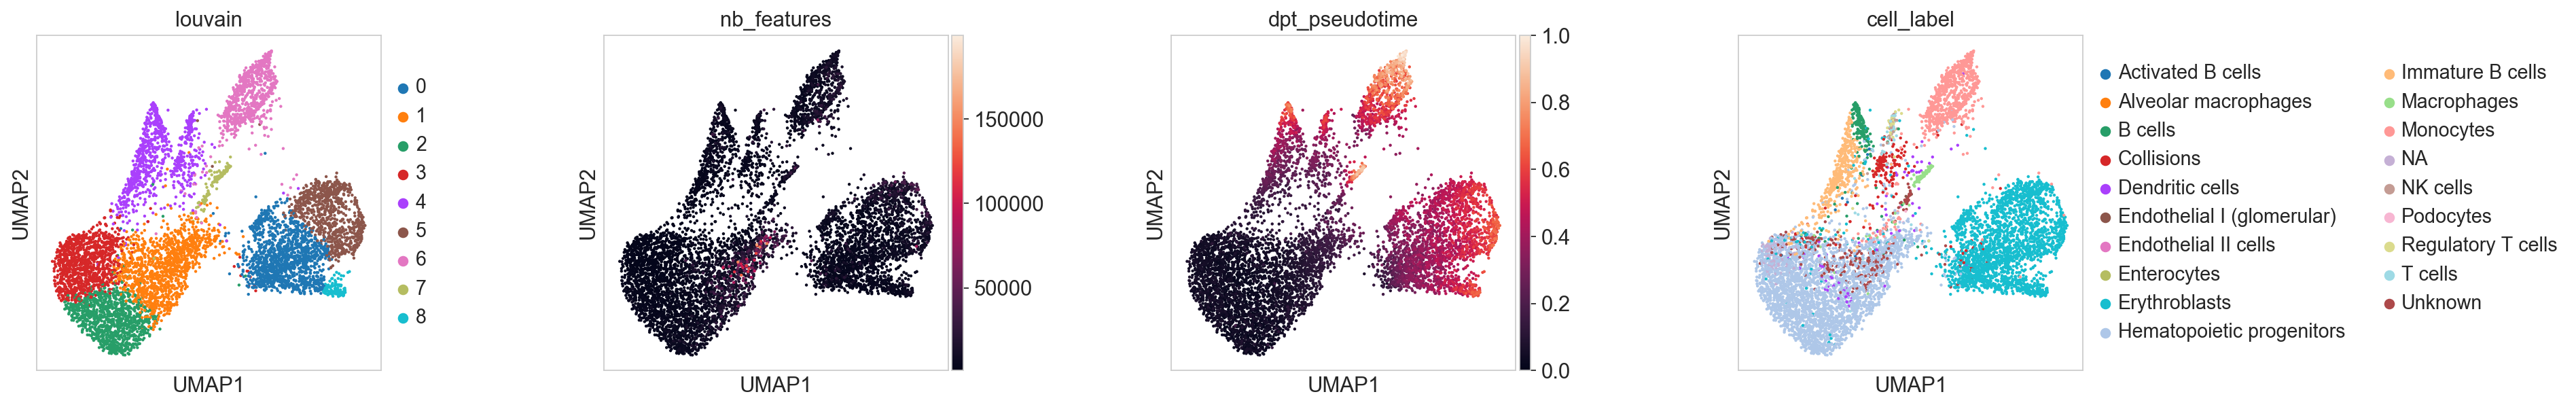

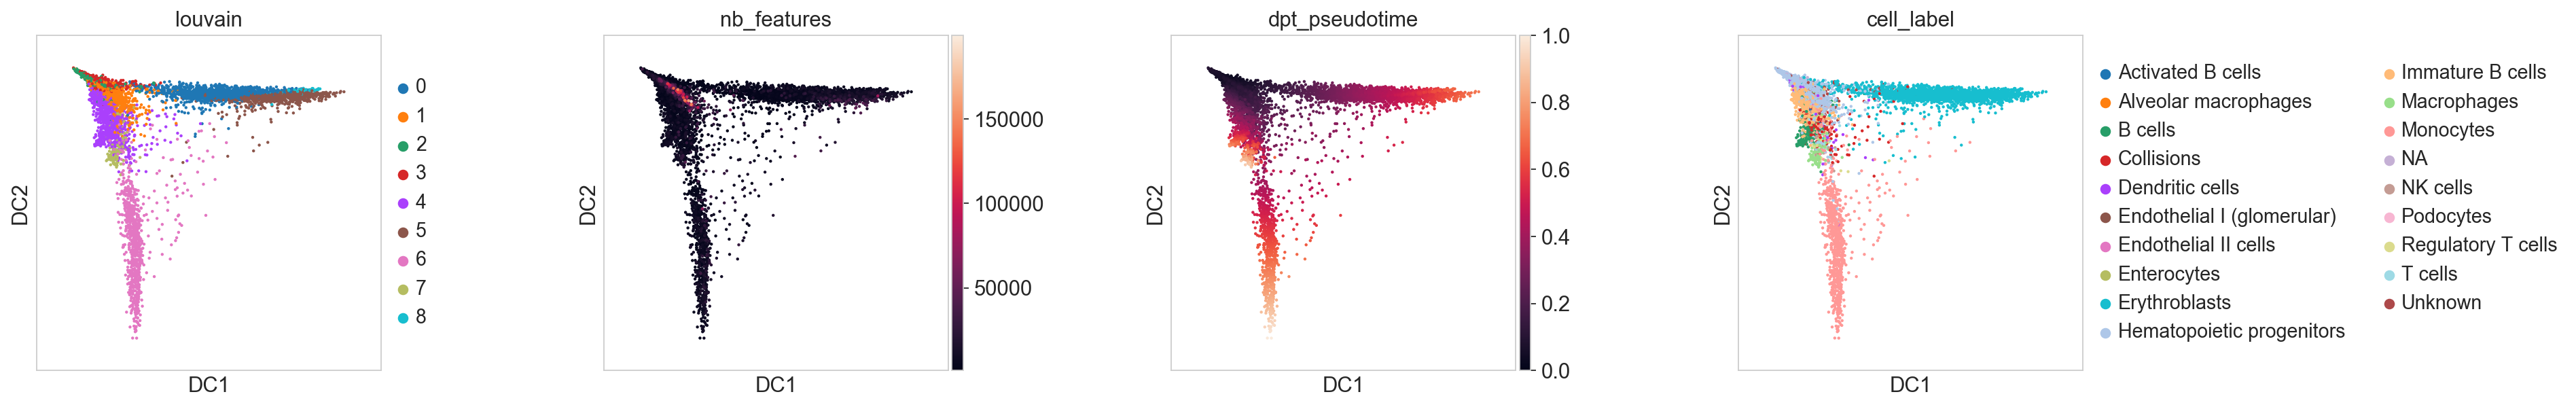

In [38]:
sc.pl.umap(adata2, color=['louvain','nb_features', 'dpt_pseudotime', 'cell_label'], wspace=0.5)
sc.pl.diffmap(adata2, color=['louvain','nb_features', 'dpt_pseudotime', 'cell_label'], wspace=0.5)

In [39]:
adata2

AnnData object with n_obs × n_vars = 7563 × 100172 
    obs: 'batch', 'cell', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2', 'cell_label', 'nb_features', 'n_counts', 'louvain', 'louvain_lowres', 'dpt_pseudotime'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'correlation_pc', 'batch_colors', 'neighbors', 'louvain', 'louvain_colors', 'louvain_lowres_colors', 'cell_label_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'

### Removing erythroblasts

In [40]:
# removing erythroblasts:
adata3 = adata2[adata2.obs['cell_label'] != 'Erythroblasts',:].copy()
adata3

AnnData object with n_obs × n_vars = 5199 × 100172 
    obs: 'batch', 'cell', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2', 'cell_label', 'nb_features', 'n_counts', 'louvain', 'louvain_lowres', 'dpt_pseudotime'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'correlation_pc', 'batch_colors', 'neighbors', 'louvain', 'louvain_colors', 'louvain_lowres_colors', 'cell_label_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'

In [ ]:
epi.pp.lazy(adata3)

Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


File "../../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplici

In [ ]:
epi.tl.louvain(adata3, key_added='louvain_noerythro')
epi.tl.diffmap(adata3)
sc.pl.umap(adata3, color=['louvain','louvain_noerythro', 'cell_label'], wspace=0.5)
sc.pl.diffmap(adata3, color=['louvain','louvain_noerythro', 'cell_label'], wspace=0.5)

In [ ]:
adata3.uns['iroot'] = np.flatnonzero(adata3.obs['louvain_noerythro']  == '1')[0]
sc.tl.dpt(adata3)

In [ ]:
sc.pl.umap(adata3, color=['louvain_noerythro','nb_features', 'dpt_pseudotime', 'cell_label'], wspace=0.5)
sc.pl.diffmap(adata3, color=['louvain_noerythro','nb_features', 'dpt_pseudotime', 'cell_label'], wspace=0.5)